# Surface code compilation

Semester project: _A practical introduction into surface code compilation_ at
[LSI](https://www.epfl.ch/labs/lsi/), EPFL.

Professor: Prof. [Giovanni De
Micheli](https://people.epfl.ch/giovanni.demicheli/?lang=en)\
Supervisor: [Mathias Soeken](https://people.epfl.ch/mathias.soeken?lang=en),
Ph.D.\
Student: [Nicolas Bähler](https://people.epfl.ch/nicolas.bahler?lang=en)

## Table of contents

- [Introduction](#introduction)
- [Theory](#theory)
  - [Surface codes](#surface-codes)
    - [Logical qubit](#logical-qubit)
    - [Elementary surface code operations](#elementary-surface-code-operations)
  - [Universality of the gate set](#universality-of-the-gate-set)
  - [Compilation of long-range CNOTs](#compilation-of-long-range-cnots)
- [Practical implementation](#practical-implementation)
- [Correctness](#correctness)
- [Further optimizations](#further-optimizations)
- [Conclusion](#conclusion)
- [Appendix](#appendix)
  - [Operations](#operations)
    - [Bell preparation](#bell-preparation)
    - [Long-range Bell preparation](#long-range-bell-preparation)
    - [Bell measurement](#bell-measurement)
    - [Hadamard](#hadamard)
    - [CNOT](#cnot)
    - [Long-range CNOT](#long-range-cnot)
    - [Move](#move)
    - [SWAP](#swap)
- [References](#references)

## [Introduction](#introduction)

The semester project is mainly based on [this
paper](https://arxiv.org/pdf/2110.11493.pdf) [\[1\]](#references). First, it
introduces surface codes as a means to implement fault-tolerant quantum
computing. Upon this basis, the authors propose a compilation scheme for quantum
circuits taking into account the geometrical constraints of todays hardware and
the surface code itself. Further, the novel technique allows to compile
significant parts of the circuit in a parallel fashion, which is a huge
advantage over naive compilation for surface codes.

This notebook will follow the structure of the paper and first introduce the
basics of surface codes and explain the compilation scheme in a
theoretical manner before presenting important aspects of an implementation of the proposed
compilation scheme.

## [Theory](#theory)

### [Surface codes](#surface-codes)

Surface codes, a special kind of Error Correcting Codes (ECCs), hold the promise
to make fault-tolerant and large-scale quantum computing possible. No physical
device is perfect and hence there is always a certain error rate for each
device. ECCs are an attempt to detect errors, generally by adding some sort of
redundancy to the information that might get degraded by an error occurring in
the device, and then correct them to ensure correctness despite the errors.

In the realm of quantum computing one needs to be specifically ingenious because
the detection of errors requires performing measurements which, generally
speaking, collapses the quantum state and hence can destroy information.

#### [Logical qubit](#logical-qubit)

The basic idea behind surface codes is simple. Assume a planar grid of qubits
and only neighbor interactions between qubits are possible. As a matter of fact,
this setup is particularly interesting as it matches todays hardware. Square
patches of _physical_ qubits, are conceptually combined into one _logical_ qubit
in a way that makes this logical qubit error correctable.

![alt text](figures/logical_qubit.png)\
_A patch of physical qubits that are used to encode in a fault-tolerant manner a
single logical qubit. [\[1\]](#references)_

The physical qubits inside a patch are split up into data qubits (black dots in
the figure above) and ancilla qubits (white dots in the figure above). Through a
set of smart measurements of the ancilla qubits only, one can infer errors that
might have occurred on the data qubits, which can then be corrected such that
the majority of the data qubits hold the correct value. In this way one can
correct a number of errors, generally referred to as the _code distance_. In the
above example, the code distance is $d=5$.

The squares having the colors either blue or red, called _plaquettes_,
as a composed system of qubits allow to detect and correct X- and Z-type errors,
respectively.

TODO transition

#### [Elementary surface code operations](#elementary-surface-code-operations)

![alt text](figures/operations.png)\
_Elementary surface code operations: Single-qubit preparation in the X basis
(i), and the Z basis (ii), destructive single-qubit measurement, in the X basis
(iii), and the Z basis (iv), two-qubit joint measurement of XX (v) and ZZ (vi),
a move of a logical qubit from one patch to an unused patch (vii), two-qubit
preparation (viii) and destructive measurement (ix) in the Bell basis, and
finally a Hadamard gate using 3 ancilla logical qubits (x).
[\[1\]](#references)_

For anyone familiar with the _Quantum Circuit Model_, this colorful picture above
seems very different from conventional quantum circuits. Each cell of the gray chessboard represents one logical qubit. On
top of that fault-tolerant structure, one can build a set of elementary gates
which are depicted in the figure above. By composing multiple elementary gates,
the gate set can be extended to be universal, in the sense that any unitary can
be approximated arbitrarily closely.

TODO add more details on the operation, go to appendix?

### [Universality of the gate set](#universality-of-the-gate-set)

The goal is to implement preparations and measurements of individual qubits in the
computational basis (Z basis), controlled-not (CNOT), Pauli-X, -Y, and -Z,
Hadamard (H), Phase S and T gates. This is a universal set of gates, in then
sense eluded to above.

The set of elementary surface code operations allows to directly implement all
but the Pauli and phase gates. As Pauli gates commute with the remaining gates of this very gate set,
they can be tracked classically and then the final measurements adapted accordingly.
Hence, there is no need to implement those physically. In order to also implement the
phase gates, a technique named _Magic State Distillation_ can be employed.

This technique uses highly specialized circuit sections, called _Magic State
Factories_, which can be in a region of the 2D grid of logical qubits far apart
from the main section where the quantum algorithm is implemented. In those
factories, initial low quality quantum states are repeatedly processed to
improve their quality until the resulting state is close enough to a target
state, hence the term _distillation_. Consuming such magic states, both phase
gates (S and T) can be fabricated. For S and T gates to be useable in the
quantum circuit that implements the unitary in question, though, there is still
a major challenge: How can those magic states be _transported_ from their factories
(potentially in a far away region of the
grid) to the location where they are needed to implement either of the phase gates?

This problem is closely related to another aspect of the surface code
architecture. As opposed to conventional quantum circuits, geometrical
constraints are taken into account in this scheme. Normally, the complexity of
physically computing a 2-operands gate on two distant qubits is completely
abstracted away. Iwth surface code architectures, which are closer to the
underlying hardware and take geometric constraints into account, one does not have the luxury to forget about the geometrical aspect of the problem.

The simplest idea to move quantum states around on the grid is to use a bunch of
SWAP gates (can be easily implemented using two move operations TODO link to
appendix?) to bring the two quantum states, the operands of the two-qubit
operation, physically close
together. But there is a catch, this requires
$Ω(k)$ SWAP gates, where $k$ is the distance between the operands.

![alt text](figures/swap_cnot.png)\
_Illustration of how SWAP gates can be used to transport the quantum state
closer together such that a CNOT can be performed. [\[1\]](#references)_

Is there a more efficient way of doing it? The answer is yes, but it
comes at the cost of some added compilation complexity! This is best understood
by going through a concrete example, here the compilation of
long-range CNOTs, meaning CNOTs between physically distant qubits.

### [Compilation of long-range CNOTs](#compilation-of-long-range-cnots)

First, let’s look at how a CNOT can be expressed in terms of elementary
operations.

![alt text](figures/cnot.png)\
_The arrow (at a for example) indicates that the result of a measurement is
stored classically in a variable, which can then be used to conditionally
perform additional operations if the variable equals $|1\rangle$, indicated by
the equal sign (at b for example). The CNOT additionally consumes a $|+\rangle$
state. [\[1\]](#references)_

The key idea, to extend this circuitry to support long-range without using SWAP
gates, is to entangle the operands using long-range Bell preparation.

![alt text](figures/long_range_bell_prep.png)\
_Bell preparation that allows to transport quantum states in costant depth. [\[1\]](#references)_

Put together, one gets the following implementation of the long-range CNOT:

![alt text](figures/long_range_cnot.png)\
_An implementation of a long-range CNOT using Bell preparation.
[\[1\]](#references)_

Note the constant depth of the circuit, although $|s\rangle$ and
$|t\rangle$ can be far apart! But those entangled chains add geometrical
complexity. On the 2D grid structure of logical qubits, the Bell
preparations can be seen as paths from target to control qubits. Additionally,
the aim is to execute as much of such operations in parallel to further improve
the performance. But hence, intersections with other Bell preparations must be avoided
to maintain correctness.

To make it easier to avoid such overlaps, one can
subdivide the 2D grid of logical qubits into
data and ancilla qubits. CNOTs can only be performed on data qubits, where the
ancillas are going to host the Bell chains between the control and the target
qubit, also referred to as _terminals_. Further, one can define a graph structure,
called _Operator Graph_, highlight in blue below, which shows all the possible paths between
different terminal pairs.

![alt text](figures/operator_paths.png)\
_Black squares are data qubits, the other ones are ancilla qubits. Further,
control data qubits (B4 for example) are only vertically connected to its
neighboring ancillas, similarly target data qubits (D2 for example) are only
adjacent to their neighbors vertically. These limitations are due to the nature
of the underling surface code. [\[1\]](#references)_

With this graph in mind, having non overlapping Bell preparations is equal to
computing vertex-disjoint paths from control to target qubits.

The same idea of using such Bell chains can be applied to transporting the
aforementioned magic states from their factories to the location on the grid
where we need to implement phase gates, thus, also at constant depth.

TODO end

## [Practical implementation](#practical-implementation)

Let’s look at a concrete example to see how the compilation works in practice.
Here 5 CNOTs (control, target) to be compiled:

1. ((H, 4), (B, 2))
2. ((B, 8), (B, 4))
3. ((F, 2), (D, 2))
4. ((B, 6), (F, 4))
5. ((F, 8), (F, 6))

The coordinates reference the 2D grid of logical qubits.

![alt text](figures/grid_cnots.png)\
_Grid_

First, some setup and imports a requires.

In [46]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

sys.path.insert(1, os.path.abspath(".."))

import tempfile
import numpy as np
from pyqir import BasicQisBuilder, SimpleModule
from abc import ABC, abstractmethod

from operator_graph import OperatorGraph
from path import DirectKeyPath, PaperKeyPath, Path, PathType
from compiler import Compiler
from helpers import append_dump_machine, flatten, unflatten
from mapper import Identity, PaperIdentity, PaperRenaming, Renaming
from qir_parser import parse_qir
from scheduler import Scheduler, assign_color_ids, Sequential
from visualizer import Visualizer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The main algorithm combines the novel technique with a
greedy algorithm based on shortest paths and finally picks the result from the
one that produces fewer epochs.

![alt text](figures/algo_3_2.png)\
_.[\[1\]](#references)_

Assume now that we want to execute a bunch of CNOTs. In a first step, we want to
connect as many of the terminals with edge-disjoint paths in the operator graph
as possible, as all those CNOTs will be executable in parallel. Note that no
data qubit can be part of the interior of the paths, and each terminal can only
be part of one path. Should a data qubit be used multiple times, there is no way
of running those CNOTs in parallel. They will have to be run in sequential
phases that I call epochs.


# TODO
- Update code
- Mention that the paper has errors for compilation
- Find good example for compilation
- Finish text
- Explain graph coloring

In [47]:
# Scheduler that is based on the paper
class EDPC(Scheduler):
    def schedule(self):
        # First approach, using the paper's novel algorithm, compute the
        # operator EDP sets
        operator_edp_sets = self.__compute_operator_edp_sets()

        # Assign color IDs to the paths
        assign_color_ids(operator_edp_sets)

        # Split operator EDP sets into operator VDP sets
        q1 = []
        for operator_edp_set in operator_edp_sets:
            p1, p2 = self.__edp_subroutine(operator_edp_set)

            q1.append(p1)

            # Check if two phases are needed
            if p2:
                q1.append(p2)

        # Second approach, using the greedy algorithm, build operator graph
        operator_graph = OperatorGraph(self._grid_dims, self._cnots)

        q2 = []
        while self._cnots:
            # Compute as many minimal length shortest path between terminal
            # pairs as possible that do not intersect
            covered_terminal_pairs, p_star = self.__greedy_vdp(
                operator_graph, self._cnots
            )

            # Make progress
            assert covered_terminal_pairs != []

            # Remove the covered terminal pairs
            for pair in covered_terminal_pairs:
                self._cnots.remove(pair)

            q2.append(p_star)

        # Assign color IDs to the paths
        assign_color_ids(q2)

        # Pick the shorter scheduling of both approaches
        if len(q1) <= len(q2):
            print(f"Using paper approach: len(q1)={len(q1)} vs len(q2)={len(q2)}")
            scheduling = q1
        else:
            print(f"Using greedy approach: len(q1)={len(q1)} vs len(q2)={len(q2)}")
            scheduling = q2

        # Contains at least one empty epoch
        if not scheduling:
            scheduling = [[]]

        return scheduling

Compute the edge-disjoint operator set.

In [48]:
class EDPC(EDPC):
    # Compute edge disjoint operator sets
    def __compute_operator_edp_sets(
        self,
    ) -> list[list[Path]]:
        paths = [PaperKeyPath(ctrl, tgt).extend_to_path() for ctrl, tgt in self._cnots]

        # Construct operator EDP sets
        operator_edp_sets = [[]]
        for (
            current_path
        ) in paths:
            added = False

            # Check if the current path is edge disjoint with all of the paths
            # of any of existing operator EDP sets and that no terminals are shared
            for operator_edp_set in operator_edp_sets:
                conflict = any(
                    not current_path.is_terminal_disjoint(set_path)
                    or not current_path.is_edge_disjoint(set_path)
                    for set_path in operator_edp_set
                )

                # Is edge disjoint with all of the paths of the current operator
                # set and does not share any terminals
                if not conflict:
                    operator_edp_set.append(current_path)
                    added = True
                    break

            # If the current path couldn't be added to any of the existing
            # operator sets, append a new operator set at the end
            if not added:
                operator_edp_sets.append([current_path])

        return operator_edp_sets

![alt text](figures/algo_3_1.png)\
_.[\[1\]](#references)_

![alt text](figures/paths.png)\
_An example of one epoch containing each data qubit at most once in any path and
being connected via edge-disjoint paths over ancilla qubits only.
[\[1\]](#references)_

Now, we still have a problem, remember when I said that those entangled chains between terminals can’t intersection each other? But that’s exactly what
we have here, look at E5 above for example. In a next step, we need to cut up
and divide the paths into two phases in a way that all path segments in each of
the two phases are vertex-disjoint. This ensures that no Bell preparations intersect
each other, at least in the same phase.


In [49]:
class EDPC(EDPC):
    # Find the vertex disjoint paths in the given operator EDP set, the
    # remaining paths are subsequently split into two operator VDP sets
    def __edp_subroutine(
        self,
        operator_edp_set: list[Path],
    ) -> tuple[list[Path], list[Path]]:
        # For each path pair check if they are vertex disjoint
        paths_to_split_idx = {}
        for i in range(len(operator_edp_set)):
            for j in range(i + 1, len(operator_edp_set)):
                current_crossing_vertices = operator_edp_set[i].crossing_vertices(
                    operator_edp_set[j]
                )

                if current_crossing_vertices != set():
                    if i in paths_to_split_idx:
                        paths_to_split_idx[i].update(
                            paths_to_split_idx[i].union(current_crossing_vertices)
                        )
                    else:
                        paths_to_split_idx[i] = set(current_crossing_vertices)

        return (
            # When the operator EDP set is not vertex disjoint, fragment it into
            # two operator VDP sets
            self.__fragment_edp_set(operator_edp_set, paths_to_split_idx)
            if paths_to_split_idx != {}
            # Otherwise return the EDP set as is (because it's VDP as well), the
            # empty second phase will be discarded
            else (operator_edp_set, [])
        )

![alt text](figures/phases_paths.png)\
_An example of one epoch that has been split up into two phases, ensuring
vertex-disjoint paths. [\[1\]](#references)_

We maximally need two phases per epoch (we might get lucky and have only none
overlapping paths in a given epoch) and we have seen that each CNOT can be run
in constant depth. Hence, each phase has constant depth as well and, thus, we
are limited by the number of epochs. This number is intrinsic to the (re)usage
and of data qubits. There is no dependence on the distance between terminals,
and we can run many CNOTs in parallel.


In [50]:
class EDPC(EDPC):
    # Given the intersecting paths and the crossing vertices, fragment the
    # operator EDP set into two operator VDP sets
    def __fragment_edp_set(
        self,
        paths: list[Path],
        paths_to_split_idx: dict[int, set[tuple[int, int]]],
    ) -> tuple[list[Path], list[Path]]:
        # Compute the vertex disjoint paths
        vertex_disjoint_path_idx = [
            i for i in range(len(paths)) if i not in paths_to_split_idx
        ]

        # Assign all vertex disjoint paths to the first phase
        p1, p2 = [paths[i] for i in vertex_disjoint_path_idx], []

        # Split the remaining paths into two phases
        for i, crossing_vertices in paths_to_split_idx.items():
            current_path = paths[i]
            phases = [1] * len(current_path)

            # Match up the crossing vertices to the second phase with the
            # required vertex before and after the crossing vertex itself
            for j, vertex in enumerate(current_path):
                if vertex in crossing_vertices:
                    assert j > 0 and j < len(current_path) - 1
                    phases[j - 1] = 2
                    phases[j] = 2
                    phases[j + 1] = 2

            phases_1 = []
            phases_2 = []

            # Attribute the vertices to the phases
            last = phases[0]
            for j, p in enumerate(phases):
                # Transition from phase 1 to phase 2
                if p > last:
                    phases_1.append(current_path[j])
                    phases_2.append(current_path[j])
                # Transition from phase 2 to phase 1
                elif p < last:
                    phases_1.extend((current_path[j - 1], current_path[j]))
                # Stay in the phase 1
                elif p == 1:
                    phases_1.append(current_path[j])
                # Stay in the phase 2
                else:
                    phases_2.append(current_path[j])

                last = p

            # Create two new paths for the two phases while maintaining the same
            # color id
            current_color_id = current_path.get_color_id()

            path = Path(PathType.PHASE_1, current_color_id, phases_1)
            p1.append(path)

            assert len(phases_1) > 1

            path = Path(PathType.PHASE_2, current_color_id, phases_2)
            p2.append(path)

            assert len(phases_2) > 1

        return p1, p2

![alt text](figures/phase_1.png)\
_.[\[1\]](#references)_

![alt text](figures/phase_2.png)\
_.[\[1\]](#references)_

![alt text](figures/algo_greedy.png)\
_.[\[2\]](#references)_

In [51]:
class EDPC(EDPC):
    # Greedily compute the set of shortest paths connecting the given terminal
    # pairs that are vertex disjoint
    def __greedy_vdp(
        self,
        operator_graph: OperatorGraph,
        terminal_pairs: list[tuple[tuple[int, int], tuple[int, int]]],
    ) -> tuple[list[tuple[tuple[int, int], tuple[int, int]]], list[Path]]:
        A: list[Path] = []
        # Remove duplicates, terminals can't be present twice (not just as pairs)
        unique_terminal_pairs = []
        used_terminals = []
        for pair in terminal_pairs:
            if pair[0] not in used_terminals and pair[1] not in used_terminals:
                unique_terminal_pairs.append(pair)
                used_terminals.extend(pair)

        covered_terminal_pairs = []
        operator_graph._restore_initial_state()

        # While not all terminal pairs have been connected
        while unique_terminal_pairs != []:
            # Compute the shortest path between any terminal pair possible in
            # the operator graph
            (
                shortest_path_terminal_pair,
                p_star,
            ) = self.__compute_minimal_length_shortest_path_between_terminal_pairs(
                operator_graph, unique_terminal_pairs
            )

            # If no such path exists, return the current set of paths
            if p_star is None:
                return covered_terminal_pairs, A

            # Remove the ancilla qubits from the operator graph used in the
            # current path
            operator_graph._remove_ancillas_in_path(p_star)
            A.append(p_star)
            covered_terminal_pairs.append(shortest_path_terminal_pair)

            # Remove the covered terminal pair from the list of terminal pairs
            unique_terminal_pairs.remove(shortest_path_terminal_pair)

        return covered_terminal_pairs, A

Minimal length

In [52]:
class EDPC(EDPC):
    # Compute the shortest path between any terminal pair possible in the
    # operator graph
    def __compute_minimal_length_shortest_path_between_terminal_pairs(
        self,
        operator_graph: OperatorGraph,
        terminal_pairs: list[tuple[tuple[int, int], tuple[int, int]]],
    ) -> tuple[tuple[tuple[int, int], tuple[int, int]], Path]:
        shortest_path_terminal_pair = None
        shortest_path = None
        length = np.inf

        # Go over all terminal pairs
        for terminal_pair in terminal_pairs:
            # Add the current terminal pair to the operator graph
            operator_graph._add_terminal_pair(terminal_pair)

            # Compute the shortest path between the two terminal vertices
            path = operator_graph._shortest_path(terminal_pair[0], terminal_pair[1])

            # Remove the current terminal pair from the operator graph again
            operator_graph._remove_terminal_pair(terminal_pair)

            # Check the current path is shorter than the shortest path found so far
            if path is not None and len(path) < length:
                length = len(path)
                shortest_path = path
                shortest_path_terminal_pair = terminal_pair

        return shortest_path_terminal_pair, shortest_path


Define intputs

In [53]:
def input_circuit1() -> tuple[SimpleModule, tuple[int, int]]:
    # Fix the grid dimensions and hence number of qubits
    grid_dims = (9, 9)
    n_qubits = int(np.prod(grid_dims))

    # Create the module
    mod = SimpleModule("input", num_qubits=n_qubits, num_results=n_qubits)
    qis = BasicQisBuilder(mod.builder)

    # Add instructions to the module
    qis.cx(mod.qubits[flatten(7, 3, grid_dims)], mod.qubits[flatten(1, 1, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 1, grid_dims)], mod.qubits[flatten(3, 1, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 5, grid_dims)], mod.qubits[flatten(5, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 7, grid_dims)], mod.qubits[flatten(1, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 7, grid_dims)], mod.qubits[flatten(5, 5, grid_dims)])

    return mod, grid_dims

In [54]:
def input_circuit2() -> tuple[SimpleModule, tuple[int, int]]:
    # Fix the grid dimensions and hence number of qubits
    grid_dims = (9, 9)
    n_qubits = int(np.prod(grid_dims))

    # Create the module
    mod = SimpleModule("input", num_qubits=n_qubits, num_results=n_qubits)
    qis = BasicQisBuilder(mod.builder)

    # Add instructions to the module
    qis.cx(mod.qubits[flatten(7, 3, grid_dims)], mod.qubits[flatten(1, 1, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 1, grid_dims)], mod.qubits[flatten(3, 1, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 5, grid_dims)], mod.qubits[flatten(5, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 7, grid_dims)], mod.qubits[flatten(1, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 7, grid_dims)], mod.qubits[flatten(5, 5, grid_dims)])

    qis.cx(mod.qubits[flatten(1, 1, grid_dims)], mod.qubits[flatten(7, 7, grid_dims)])
    qis.cx(mod.qubits[flatten(7, 1, grid_dims)], mod.qubits[flatten(3, 5, grid_dims)])
    qis.cx(mod.qubits[flatten(3, 5, grid_dims)], mod.qubits[flatten(5, 5, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 5, grid_dims)], mod.qubits[flatten(7, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 7, grid_dims)], mod.qubits[flatten(5, 5, grid_dims)])

    qis.cx(mod.qubits[flatten(7, 3, grid_dims)], mod.qubits[flatten(3, 7, grid_dims)])
    qis.cx(mod.qubits[flatten(3, 1, grid_dims)], mod.qubits[flatten(3, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 7, grid_dims)], mod.qubits[flatten(5, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(1, 3, grid_dims)], mod.qubits[flatten(7, 5, grid_dims)])
    qis.cx(mod.qubits[flatten(5, 1, grid_dims)], mod.qubits[flatten(1, 1, grid_dims)])

    qis.cx(mod.qubits[flatten(1, 3, grid_dims)], mod.qubits[flatten(7, 3, grid_dims)])
    qis.cx(mod.qubits[flatten(3, 1, grid_dims)], mod.qubits[flatten(3, 7, grid_dims)])

    return mod, grid_dims

In [55]:
# Choose the input circuit
# input_circuit = input_circuit1
input_circuit = input_circuit2

Setup

In [56]:
# Generated circuit using the QIR-Alliance generator
mod, grid_dims = input_circuit()

# Get the root directory of the project
root_dir = os.path.abspath("../..")

# Write temporary llvm file so that the parser can read it
with tempfile.NamedTemporaryFile(suffix=".ll") as f:
    f.write(mod.ir().encode("utf-8"))
    f.flush()
    cnots = parse_qir(f.name)

# Append dump machine to the end of the circuit
append_dump_machine(mod)

# Write llvm file that can be run by the qir-runner
with open(os.path.join(root_dir, "qir/input.ll"), "wb") as f:
    f.write(mod.ir().encode("utf-8"))
    f.flush()

print("CNOTs: (control, target)")
print(cnots)

CNOTs: (control, target)
[(66, 10), (46, 28), (14, 48), (16, 12), (52, 50), (10, 70), (64, 32), (32, 50), (14, 66), (52, 50), (66, 34), (28, 30), (52, 48), (12, 68), (46, 10), (12, 66), (28, 34)]


Pick strategies and compute mapping

In [57]:
# Select strategies
# mapping_strategy, scheduling_strategy = Identity, Sequential
# mapping_strategy, scheduling_strategy = Renaming, Sequential
mapping_strategy, scheduling_strategy = PaperIdentity, EDPC
# mapping_strategy, scheduling_strategy = PaperRenaming, EDPC

print("Infos:")

# Map the qubits according to strategy
(n_qubits, mapping, grid_dims) = mapping_strategy(grid_dims, cnots).map()

print(f"Number of qubits used: {n_qubits}")
print(f"Mapping of qubits: {mapping}")

Infos:
Number of qubits used: 81
Mapping of qubits: {66: 66, 10: 10, 46: 46, 28: 28, 14: 14, 48: 48, 16: 16, 12: 12, 52: 52, 50: 50, 70: 70, 64: 64, 32: 32, 34: 34, 30: 30, 68: 68}


Compute the scheduling

In [58]:
# Schedule the CNOTs according to strategy
scheduling = scheduling_strategy(grid_dims, cnots, mapping).schedule()

scheduling_str = ",\n".join(
    [
        ",\n".join([f"{i+1}.{j+1} {path}" for j, path in enumerate(phase)])
        for i, phase in enumerate(scheduling)
    ]
)
print(f"Scheduling: (phase.path)\n{scheduling_str}")

Using greedy approach: len(q1)=7 vs len(q2)=4
Scheduling: (phase.path)
1.1 [(F, 2), (E, 2), (E, 1), (D, 1), (D, 2)],
1.2 [(F, 8), (E, 8), (E, 7), (F, 7), (F, 6)],
1.3 [(B, 6), (C, 6), (C, 5), (D, 5), (E, 5), (F, 5), (F, 4)],
1.4 [(B, 8), (A, 8), (A, 7), (A, 6), (A, 5), (B, 5), (B, 4)],
1.5 [(H, 4), (G, 4), (G, 3), (F, 3), (E, 3), (D, 3), (C, 3), (B, 3), (B, 2)],
1.6 [(H, 2), (I, 2), (I, 3), (I, 4), (I, 5), (I, 6), (I, 7), (I, 8), (I, 9), (H, 9), (G, 9), (F, 9), (E, 9), (D, 9), (C, 9), (C, 8), (C, 7), (D, 7), (D, 6)],
2.1 [(D, 6), (E, 6), (E, 5), (F, 5), (F, 6)],
2.2 [(D, 2), (C, 2), (C, 3), (D, 3), (D, 4)],
2.3 [(F, 8), (G, 8), (G, 7), (G, 6), (G, 5), (F, 5), (F, 4)],
2.4 [(B, 6), (C, 6), (C, 5), (C, 4), (C, 3), (D, 3), (E, 3), (F, 3), (G, 3), (H, 3), (H, 4)],
2.5 [(B, 2), (A, 2), (A, 3), (A, 4), (A, 5), (A, 6), (A, 7), (A, 8), (A, 9), (B, 9), (C, 9), (D, 9), (E, 9), (F, 9), (G, 9), (H, 9), (H, 8)],
3.1 [(F, 8), (E, 8), (E, 7), (F, 7), (F, 6)],
3.2 [(F, 2), (E, 2), (E, 1), (D, 1), (C, 

Compile the scheduling into qir

In [59]:
# Compile the scheduled CNOTs into QIR
out_qir = Compiler(grid_dims, scheduling).compile()

# Write the output QIR
with open(os.path.join(root_dir, "qir/output.ll"), "wb") as f:
    f.write(out_qir.encode("utf-8"))
    f.flush()

Visualize the scheduling 

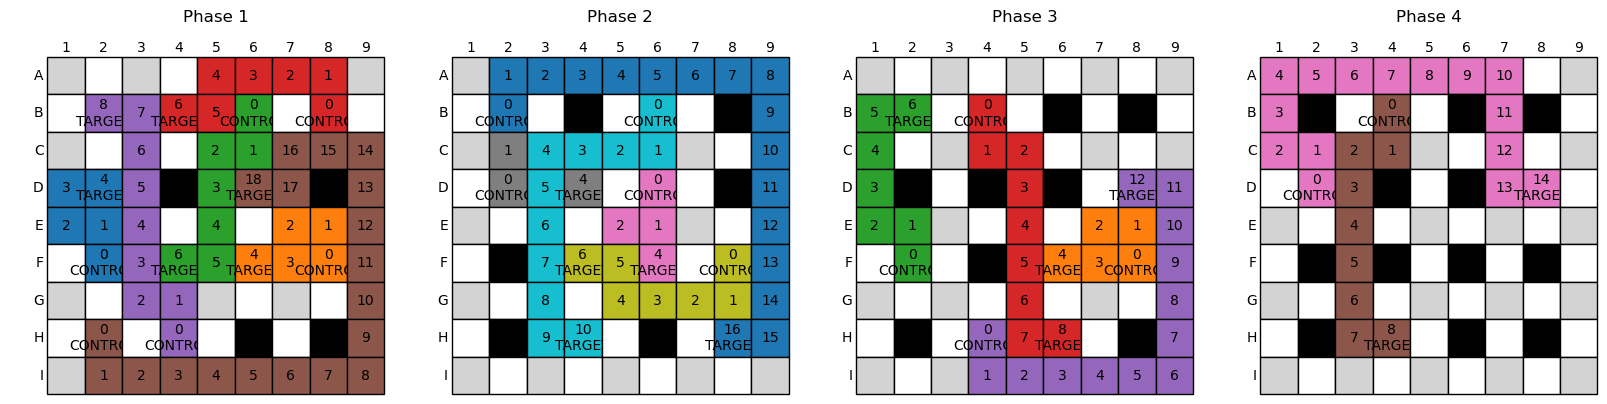

In [60]:
# Visualize the scheduling
Visualizer(grid_dims, scheduling).visualize()

## [Correctness](#correctness)

In order to check the correctness of the implementation sparse simulation of the
resulting QIR is performed. 

In [61]:
ret = os.system("cd ../../qir-runner && cargo run ../qir/input.ll")
assert ret == 0

START
METADATA	EntryPoint
METADATA	requiredQubits	81
METADATA	requiredResults	81
STATE: [ |0⟩: 1+0i, ]
END	0


    Finished dev [unoptimized + debuginfo] target(s) in 0.04s
     Running `target/debug/qir-runner ../qir/input.ll`


Compiled version

In [62]:
ret = os.system("cd ../../qir-runner && cargo run ../qir/output.ll")
assert ret == 0

    Finished dev [unoptimized + debuginfo] target(s) in 0.06s
     Running `target/debug/qir-runner ../qir/output.ll`


START
METADATA	EntryPoint
METADATA	requiredQubits	82
METADATA	requiredResults	86
Global Results: [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]
STATE: [ |2417925426205553187618816⟩: 0.08838834764831846+0i, |2417925426205553187622912⟩: -0.08838834764831846+-0i, |2417925426205553456054272⟩: 0.08838834764831846+0i, |2417925426205553456058368⟩: -0.08838834764831846+-0i, |2417925426205554261360640⟩: 0.08838834764831846+0i, |2417925426205554261364736⟩: -0.08838834764831846+-0i, |2417925426205554529796096⟩: 0.08838834764831846+0i, |2417925426205554529800192⟩: -0.08838834764831846+-0i, |2417925426205557482586112⟩: -0.08838834764831846+-0i, |2417925426205557482590208⟩: 0.08838834764831846+0i, |2417925426205557751021568⟩: -0.08838834764831846+-0i, |2417925426205557751025664⟩: 0.088388347

## [Further optimizations](#further-optimizations)

One can think of further optimizations steps, that are not discussed in the
paper. One idea would be to compute a smart mapping of qubits onto the grid,
which leads to shorter paths and fewer intersections. Another one is instruction
reordering, similar to what modern CPUs do to improve instruction level
parallelism.

## [Conclusion](#conclusion)

The technique I sketched out for you is fascinating, but it needs many qubits.
As new quantum chips with
more and more qubits are being developed at an ever-increasing pace, I think the
in a _near future_, surface codes will be the basis of fault-tolerant large
scale quantum computing.

## [Appendix](#appendix)

### [Operations](#operations)

#### [Bell preparation](#bell-preparation)

![alt text](figures/bell_prep.png)\
_text. [\[1\]](#references)_

#### [Long-range Bell preparation](#long-range-bell-preparation)

![alt text](figures/long_range_bell_prep.png)\
_text. [\[1\]](#references)_

#### [Bell measurement](#bell-measurement)

![alt text](figures/bell_meas.png)\
_text. [\[1\]](#references)_

#### [Hadamard](#hadamard)

![alt text](figures/hadamard.png)\
_text. [\[1\]](#references)_

#### [CNOT](#cnot)

![alt text](figures/cnot.png)\
_text. [\[1\]](#references)_

#### [Long-range CNOT](#long-range-cnot)

![alt text](figures/long_range_cnot.png)\
_text. [\[1\]](#references)_

#### [Move](#move)

![alt text](figures/move.png)\
_text. [\[1\]](#references)_

#### [SWAP](#swap)

![alt text](figures/swap.png)\
_text. [\[1\]](#references)_

## [References](#references)

- [1] https://arxiv.org/pdf/2110.11493.pdf
- [2] https://doi.org/10.1007/s10107-002-0370-6
